# Прогнозирование индекса промышленного производства

Для предсказания изменений в индексе промышленного производства применяется методика градиентного бустинга с использованием библиотеки CatBoost

### Определяющие признаки:
- Новостной индекс ЦБ (news)
- Индекс цен на электроэнергию в первой ценовой зоне (consumer_price)
- Промышленность (cb_monitor)
- Индикатор бизнес климата (bussines_clim)
- Курс рубля (curs)
- Погрузка на сети РЖД (rzd)

Каждый признак имеет разный лаг эффекта на экономику. Поэтому для различных прогнозов будут созданы столбцы с лагами __(с постфиксом lag_i)__ Более того, при прогнозе более чем на месяц, новостной индекс ЦБ имеет все большую предсказательную силу

Для каждого из трех прогнозируемых периодов обучается отдельная модель, поскольку лаг-переменные, отражающие временные сдвиги в воздействии факторов, фактически представляют собой новые признаки

## Импорт библиотек и установка зависимостей

In [1]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/pycups-2.0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/PyPDF3-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [1]:
import pandas as pd
import datetime
import numpy as np

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Импорт данных

In [2]:
df = pd.read_csv('../data/preprocessed_ipp_factors.csv', index_col='Unnamed: 0')

df.date = pd.to_datetime(df.date).dt.date

In [3]:
df.head(3)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd,interest_rate
0,2015-01-31,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,15.380952
1,2015-02-28,99.8,-1.756337,1156.01,-11.936877,2.572276,64.518174,92.5,13.789474
2,2015-03-31,101.9,-1.972270,1167.50,-7.194668,6.963493,60.363090,103.0,13.409091


# Добавление столбцов с лаггом

### Лаги для признаков:
- __Новостной индекс ЦБ (news):__ 1 месяц
- __Индекс цен на электроэнергию в первой ценовой зоне (consumer_price):__ 0 месяцев
- __Промышленность (cb_monitor):__ 2 месяца
- __Индикатор бизнес климата (bussines_clim):__ 2 месяца
- __Курс рубля (curs):__ 0 месяцев
- __Погрузка на сети РЖД (rzd):__ 1 месяц
- __Среднемесячная ключевая ставка ЦБ (interest_rate)__: 

In [4]:
df.head(1)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd,interest_rate
0,2015-01-31,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,15.380952


In [17]:
for i in range(1, 6 + 1):
    df[f'goal_lag_{i}'] = df['goal'].shift(i) ** 2
    df[f'news_lag_{i}'] = df['news'].shift(i)
    df[f'bussines_clim_lag_{i}'] = df['bussines_clim'].shift(i)
    df[f'cb_monitor_lag_{i}'] = df['cb_monitor'].shift(i)
    df[f'rzd_lag_{i}'] = df['rzd'].shift(i)
    df[f'consumer_price_lag_{i}'] = df['consumer_price'].shift(i)
    df[f'interest_rate_lag_{i + 3}'] = df['interest_rate'].shift(i)
    df[f'curs_lag_{i}'] = df['curs'].shift(i)

df = df.fillna(method='pad')

In [18]:
df.columns

Index(['date', 'goal', 'news', 'consumer_price', 'cb_monitor', 'bussines_clim',
       'curs', 'rzd', 'interest_rate', 'goal_lag_1', 'news_lag_1',
       'bussines_clim_lag_1', 'cb_monitor_lag_1', 'rzd_lag_1',
       'interest_rate_lag_4', 'goal_lag_2', 'news_lag_2',
       'bussines_clim_lag_2', 'cb_monitor_lag_2', 'rzd_lag_2',
       'interest_rate_lag_5', 'goal_lag_3', 'news_lag_3',
       'bussines_clim_lag_3', 'cb_monitor_lag_3', 'rzd_lag_3',
       'interest_rate_lag_6', 'goal_lag_4', 'news_lag_4',
       'bussines_clim_lag_4', 'cb_monitor_lag_4', 'rzd_lag_4',
       'interest_rate_lag_7', 'goal_lag_5', 'news_lag_5',
       'bussines_clim_lag_5', 'cb_monitor_lag_5', 'rzd_lag_5',
       'interest_rate_lag_8', 'goal_lag_6', 'news_lag_6',
       'bussines_clim_lag_6', 'cb_monitor_lag_6', 'rzd_lag_6',
       'interest_rate_lag_9', 'consumer_price_lag_1', 'consumer_price_lag_2',
       'consumer_price_lag_3', 'consumer_price_lag_4', 'consumer_price_lag_5',
       'consumer_price_lag_6

In [5]:
df.head(3)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd,interest_rate,goal_lag_1,...,bussines_clim_lag_5,cb_monitor_lag_5,rzd_lag_5,interest_rate_lag_8,goal_lag_6,news_lag_6,bussines_clim_lag_6,cb_monitor_lag_6,rzd_lag_6,interest_rate_lag_9
0,2015-01-31,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,15.380952,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-28,99.8,-1.756337,1156.01,-11.936877,2.572276,64.518174,92.5,13.789474,10261.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-03-31,101.9,-1.972270,1167.50,-7.194668,6.963493,60.363090,103.0,13.409091,9960.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Стационарность ряда

In [44]:
from statsmodels.tsa.stattools import adfuller, kpss

In [45]:
adfuller(df.goal)

(-2.590156990581484,
 0.09504873012091847,
 13,
 94,
 {'1%': -3.5019123847798657,
  '5%': -2.892815255482889,
  '10%': -2.583453861475781},
 403.9761667346637)

In [64]:
result = adfuller(df.goal)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

print(f'Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -2.590156990581484
p-value: 0.09504873012091847
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583


In [65]:
result = kpss(df.goal, nlags=12)

print(f'p-value: {result[0]}')
print(f'Critical Values:')
for key, value in result[3].items():
    print(f'\t{key}: {value:.3f}')

p-value: 0.07129276944008818
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/tmp/ipykernel_2423/4210407378.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df.goal, nlags=12)


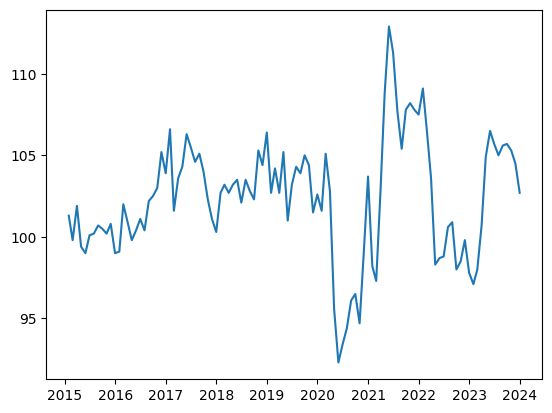

In [105]:
plt.plot(df.date, df.goal)

Дисперсия растет со временем

# Ключевая ставка

В зависимости от лага (6-9 месяцев) или 2 года меняется коэффициент корреляции между 

Связь ИПП и ключевой ставки очевидно отрицательна, но дальнейший рост видимо вызван именно правильной политикой ЦБ, которая и приводит к росту промышленности после антикризисных мер

(-1.0, 1.0)

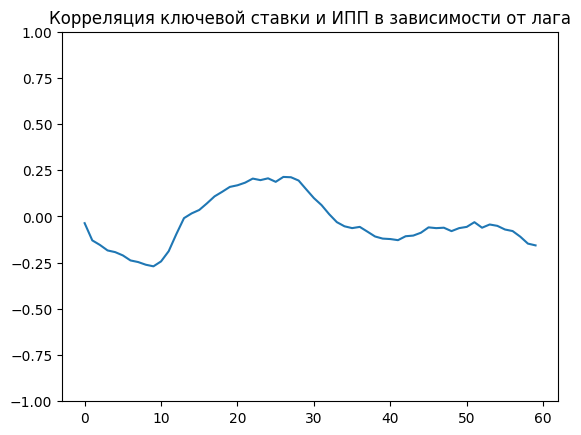

In [10]:
plt.title('Корреляция ключевой ставки и ИПП в зависимости от лага')

plt.plot(range(60), [df['interest_rate'].shift(i).corr(df.goal) for i in range(60)])
plt.ylim([-1, 1])

In [12]:
# Лаг в 9 месяцев
df['interest_rate']\
    .shift(9)\
    .corr(df.goal)

-0.26975355896241526

In [13]:
# Лаг в 2 года
df['interest_rate']\
    .shift(24)\
    .corr(df.goal)

0.20642284164738492

## Корреляция ИПП с признаками (с лаггом)

экзогенные переменные для прогнозирования на 1 месяц вперед

In [8]:
exog_var = ['news_lag_1', 'consumer_price', 'cb_monitor_lag_2', 'bussines_clim_lag_1', 'curs', 'rzd_lag_1', 'interest_rate_lag_6']

<Axes: >

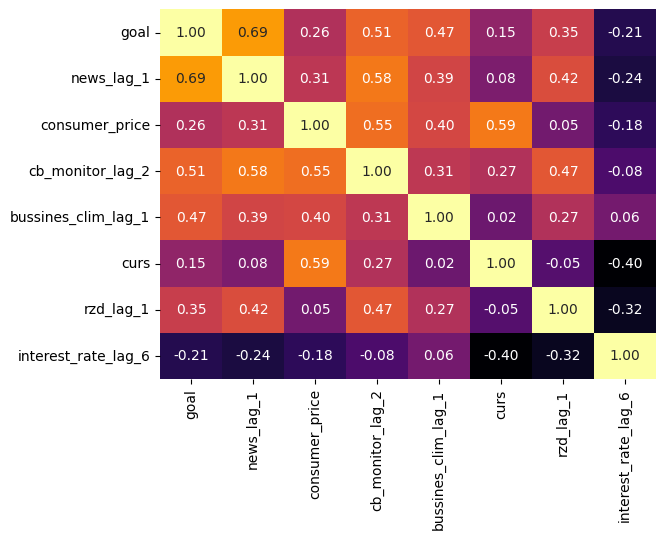

In [9]:
sns.heatmap(
    df[['goal'] + exog_var].corr(),
    fmt=".2f",
    # ax=ax,
    annot=True,
    cmap='inferno',
    cbar=False
)

Заметим, что cb_monitor и bussines_clim сильно коррелируемы: попробуем с помощью метода главных компонентов выделить главную компоненту

# Определим порядок признаков для модели CatBoost

Порядок признаков важен для модели, сортировать их по корреляции не очень правильно, поэтому экономически обоснуем их порядок

1. Первым пойдет новостной индекс, поскольку на производство достаточно сильно влияют настроения в обществе и этот индекс лучше всего это отражает
2. Далее, идут индексы для бизнеса в россии
3. Потом ключевая ставка
4. Потом поставки РЖД
5. В конце курс, потому что производство в РФ все меньше зависит от импорта и курса валют

In [117]:
exog_var = [
    'goal_lag_1',
    'goal_lag_2',
    'news_lag_1',
    'news_lag_2',
    'news_lag_3',
    'cb_monitor_lag_2',
    'bussines_clim_lag_1',
    'rzd_lag_1',
    'interest_rate_lag_4',
    'consumer_price',
    'curs',
]

# Сделаем прогноз на 1 месяц

Для этого обучим модель по следующим признакам:

Поделим на обучающую и тестовую выборку 80/20

In [8]:
def train_test_split(exog_var, goal):
    X_train = df[df.date < datetime.date(year=2022, month=5, day=31)][exog_var].fillna(method='bfill')
    Y_train = df[df.date < datetime.date(year=2022, month=5, day=31)][goal].fillna(method='bfill')
    
    X_test = df[df.date >= datetime.date(year=2022, month=5, day=31)][exog_var]
    Y_test = df[df.date >= datetime.date(year=2022, month=5, day=31)][goal]
    
    return X_train, X_test, Y_train, Y_test

In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(exog_var, 'goal')

model = CatBoostRegressor(verbose=False, loss_function='RMSE')

grid = {
    'iterations':    [6, 8, 16, 32], 
    'depth':         [3, 6, 8, 10],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res = model.grid_search(
    grid, X_train, Y_train, 
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 101.2418716
bestIteration = 5


bestTest = 95.96258431
bestIteration = 5


bestTest = 54.60207864
bestIteration = 5


bestTest = 2.847790042
bestIteration = 5


bestTest = 2.365858019
bestIteration = 3


bestTest = 101.2421035
bestIteration = 5


bestTest = 95.96479916
bestIteration = 5


bestTest = 54.6156941
bestIteration = 5


bestTest = 2.849305278
bestIteration = 5


bestTest = 2.361499387
bestIteration = 3


bestTest = 101.2461746
bestIteration = 5


bestTest = 96.00370073
bestIteration = 5


bestTest = 54.8561837
bestIteration = 5


bestTest = 2.892856617
bestIteration = 5


bestTest = 2.365751667
bestIteration = 1


bestTest = 101.2522476
bestIteration = 5


bestTest = 96.06129709
bestIteration = 5


bestTest = 55.18403659
bestIteration = 5


bestTest = 3.334856904
bestIteration = 5


bestTest = 2.445375714
bestIteration = 5


bestTest = 101.2716563
bestIteration = 5


bestTest = 96.24741892
bestIteration = 5


bestTest = 56.38706235
bestIteration = 5


bestTest = 4

In [120]:
res['params']

{'depth': 3, 'learning_rate': 1, 'l2_leaf_reg': 0.005, 'iterations': 6}

{'depth': 3, 'learning_rate': 0.5, 'l2_leaf_reg': 0.005, 'iterations': 8}

In [125]:
model = CatBoostRegressor(**res['params'], verbose = False)
model.fit(X_train, Y_train)

### Качество модели:

In [23]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [126]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(Y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(Y_train, train_predict), 3) * 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(Y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.988
mape train: 0.3%
mape test: 2.0%


# Пробуем поменять параметры

Есть гипотеза, что нужно выделить главную компоненту из cb_monitor и bussines_clim, поскольку они очень коррелируемы

In [184]:
df.cb_monitor\
    .corr(df.bussines_clim)

0.7878607126804216

Создадим модели без каждой из них и сравним качество метрик

### Без бизнес климата:

In [141]:
new_exog_var = ['news_lag_1', 'cb_monitor_lag_2', 'interest_rate_lag_6', 'rzd_lag_1', 'consumer_price', 'curs']

X_train, X_test, Y_train, Y_test = train_test_split(new_exog_var, 'goal')

model = CatBoostRegressor(**res['params'], verbose=False)
model.fit(X_train, Y_train)

In [142]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(Y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(Y_train, train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(Y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.794
mape train: 1.2%
mape test: 2.8%


### Без cb_monitor

In [143]:
new_exog_var = ['news_lag_1', 'bussines_clim_lag_1', 'interest_rate_lag_5', 'rzd_lag_1', 'consumer_price', 'curs']

X_train, X_test, Y_train, Y_test = train_test_split(new_exog_var, 'goal')

model = CatBoostRegressor(**res['params'], verbose=False)
model.fit(X_train, Y_train)

In [144]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(Y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(Y_train, train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(Y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.791
mape train: 1.3%
mape test: 2.4%


их исключение на качество модели влияет незначительно, однако 

# Модель для прогноза на 2 месяца

In [130]:
exog_var_2 = [
    'goal_lag_2',
    'news_lag_2',
    'news_lag_3',
    'news_lag_4',
    'cb_monitor_lag_3',
    'bussines_clim_lag_2',
    'rzd_lag_2',
    'interest_rate_lag_5',
    'consumer_price_lag_1',
    'curs_lag_1',
]

In [131]:
X_train, X_test, Y_train, Y_test = train_test_split(exog_var_2, 'goal_lag_1')

model_2 = CatBoostRegressor(verbose=False, loss_function='RMSE')

grid = {
    'iterations':    [6, 8, 16, 32], 
    'depth':         [3, 6, 8, 10],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res_2 = model_2.grid_search(
    grid, X_train, Y_train, 
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0
)

model_2 = CatBoostRegressor(**res_2['params'], verbose=False)
model_2.fit(X_train.fillna(method='bfill'), Y_train.fillna(method='bfill'))


bestTest = 10423.3801
bestIteration = 5


bestTest = 9871.754143
bestIteration = 5


bestTest = 5572.779138
bestIteration = 5


bestTest = 553.1844007
bestIteration = 5


bestTest = 579.5157076
bestIteration = 0


bestTest = 10423.40508
bestIteration = 5


bestTest = 9871.99282
bestIteration = 5


bestTest = 5574.256496
bestIteration = 5


bestTest = 553.4236033
bestIteration = 5


bestTest = 579.6015865
bestIteration = 0


bestTest = 10423.84746
bestIteration = 5


bestTest = 9876.220355
bestIteration = 5


bestTest = 5600.503478
bestIteration = 5


bestTest = 559.2066369
bestIteration = 5


bestTest = 594.5946838
bestIteration = 0


bestTest = 10425.66664
bestIteration = 5


bestTest = 9893.624707
bestIteration = 5


bestTest = 5709.97566
bestIteration = 5


bestTest = 607.7985695
bestIteration = 5


bestTest = 772.0952882
bestIteration = 1


bestTest = 10428.53379
bestIteration = 5


bestTest = 9921.251089
bestIteration = 5


bestTest = 5898.235653
bestIteration = 5


bestTest = 69

In [132]:
train_predict = model_2.predict(X_train.fillna(method='bfill'))
test_predict = model_2.predict(X_test)

print(f'r2_score: {np.round(r2_score(Y_train.fillna(method="bfill"), train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(Y_train.fillna(method="bfill"), train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(Y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.886
mape train: 2.0%
mape test: 3.9%


r2_score: 0.827
mape train: 2.2%
mape test: 6.0%

In [78]:
model_2.predict(df[exog_var_2].iloc[-2]) ** 0.5

105.65595021118129

# Прогноз на 3 месяца

In [136]:
exog_var_3 = [
    'goal_lag_3',
    'news_lag_3',
    'news_lag_4',
    'news_lag_5',
    'cb_monitor_lag_4',
    'bussines_clim_lag_3',
    'rzd_lag_3',
    'interest_rate_lag_6',
    'consumer_price_lag_2',
    'curs_lag_2',
]

In [138]:
X_train, X_test, Y_train, Y_test = train_test_split(exog_var_3, 'goal_lag_2')

model_3 = CatBoostRegressor(verbose=False, loss_function='RMSE')

grid = {
    'iterations':    [6, 8, 16, 32], 
    'depth':         [3, 6, 8, 10],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res_3 = model_3.grid_search(
    grid, X_train, Y_train, 
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0
)

model_3 = CatBoostRegressor(**res_3['params'], verbose=False)
model_3.fit(X_train.fillna(method='bfill'), Y_train.fillna(method='bfill'))


bestTest = 10348.9378
bestIteration = 5


bestTest = 9803.309261
bestIteration = 5


bestTest = 5549.166416
bestIteration = 5


bestTest = 450.4212545
bestIteration = 5


bestTest = 461.5672328
bestIteration = 1


bestTest = 10348.96069
bestIteration = 5


bestTest = 9803.527634
bestIteration = 5


bestTest = 5550.485527
bestIteration = 5


bestTest = 450.275785
bestIteration = 5


bestTest = 489.8747061
bestIteration = 1


bestTest = 10349.36803
bestIteration = 5


bestTest = 9807.413877
bestIteration = 5


bestTest = 5574.067424
bestIteration = 5


bestTest = 449.0921691
bestIteration = 5


bestTest = 526.1779796
bestIteration = 5


bestTest = 10351.07677
bestIteration = 5


bestTest = 9823.741153
bestIteration = 5


bestTest = 5675.022888
bestIteration = 5


bestTest = 469.7580069
bestIteration = 5


bestTest = 492.5148502
bestIteration = 5


bestTest = 10353.01213
bestIteration = 5


bestTest = 9842.272878
bestIteration = 5


bestTest = 5792.573091
bestIteration = 5


bestTest = 5

In [139]:
train_predict = model_3.predict(X_train.fillna(method='bfill'))
test_predict = model_3.predict(X_test)

print(f'r2_score: {np.round(r2_score(Y_train.fillna(method="bfill"), train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(Y_train.fillna(method="bfill"), train_predict), 3)* 100:0.1f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(Y_test, test_predict), 3) * 100:0.1f}%')

r2_score: 0.993
mape train: 0.5%
mape test: 4.0%


# Визуализация

In [79]:
forecast = pd.DataFrame(columns=['date', 'goal_predict'])
forecast.date = [datetime.date(year=2024, month=i, day=27) for i in range(1, 3 + 1)]

In [140]:
forecast.goal_predict.iloc[0] = model.predict(df[exog_var].iloc[-1])
forecast.goal_predict.iloc[1] = model_2.predict(df[exog_var_2].iloc[-1]) ** 0.5
forecast.goal_predict.iloc[2] = model_3.predict(df[exog_var_3].iloc[-1]) ** 0.5

In [141]:
forecast

,date,goal_predict
0,2024-01-27,102.344703
1,2024-02-27,104.388616
2,2024-03-27,104.35689


(17986.0, 19908.0)

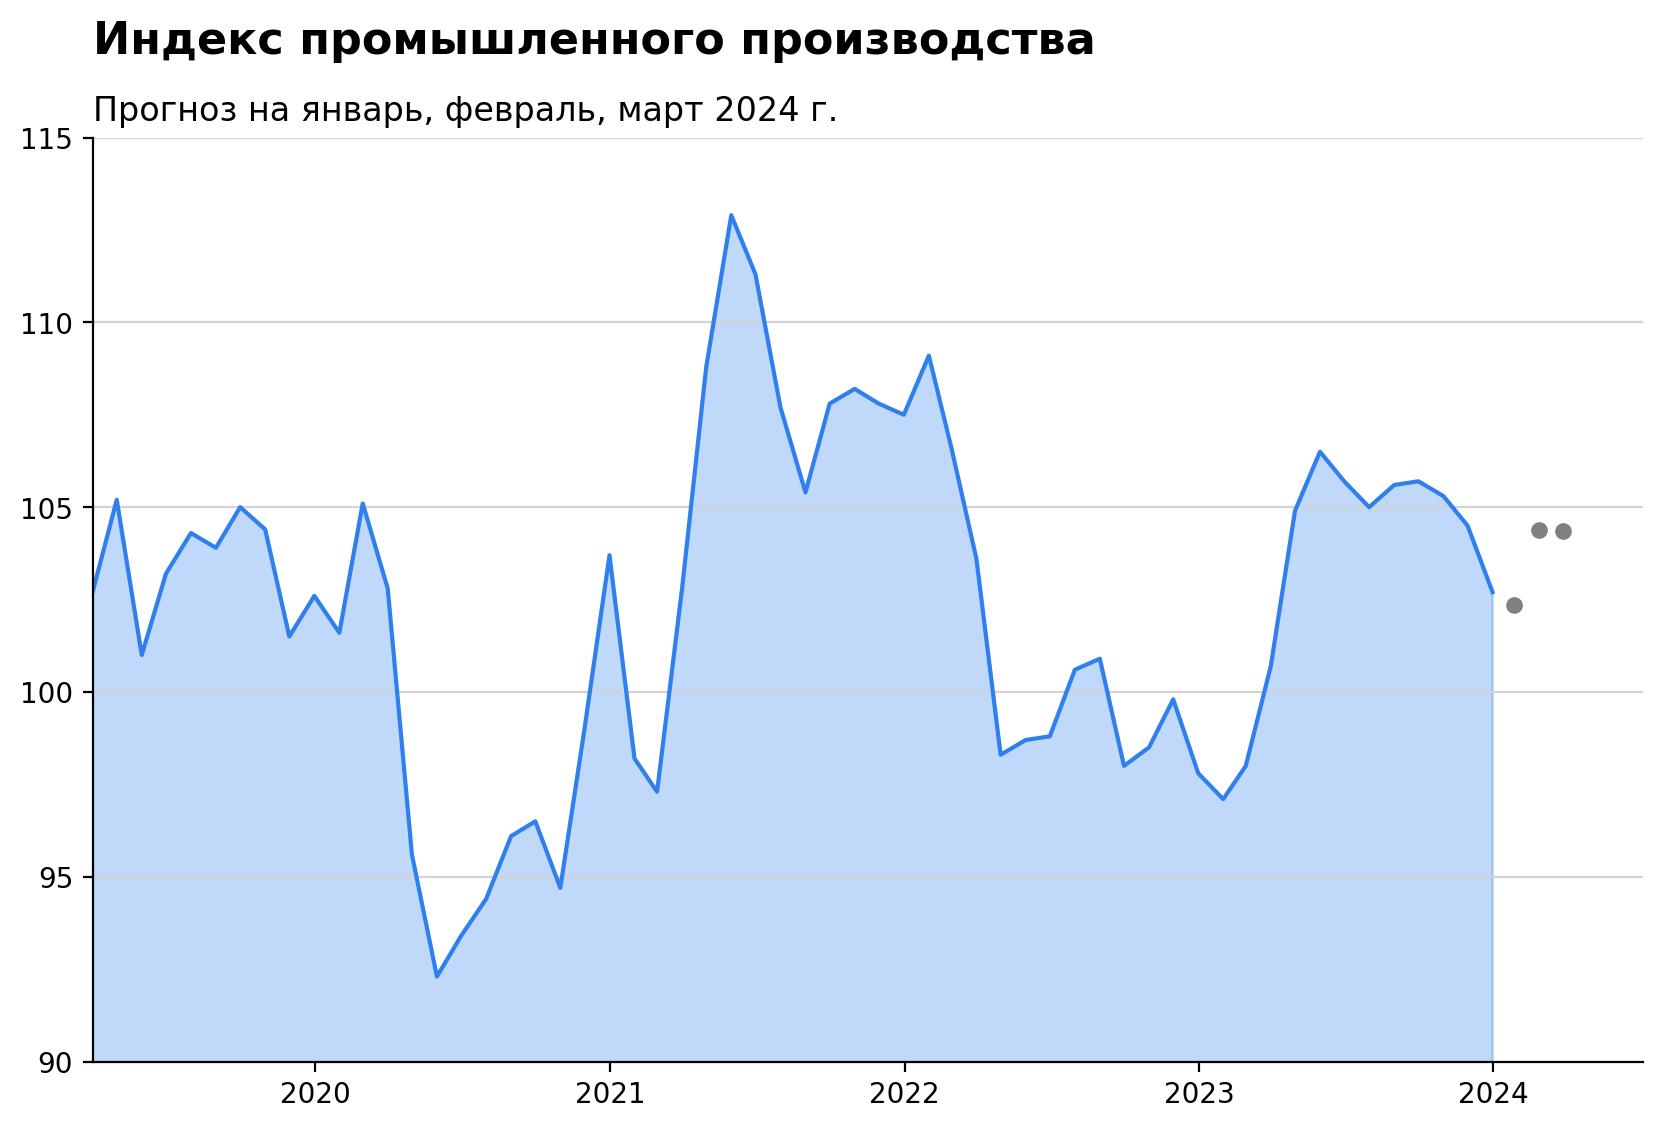

In [142]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

fig.text(y=.95, x=.125, s="Индекс промышленного производства",fontsize=16, fontweight="bold")
plt.title("Прогноз на январь, февраль, март 2024 г.",fontsize=12, loc='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(axis='y', color='lightgrey')

ax.plot(df.date, df.goal, color='#2F80ED')
ax.fill_between(df.date, df.goal, color='#2F80ED', alpha=0.3)

ax.scatter(forecast.date, forecast.goal_predict, color='grey', s=25)

ax.set_ylim([90, 115])
ax.set_xlim([df.date.iloc[50], df.date.iloc[-1] + datetime.timedelta(days=31 * 6)])